In [1]:
%load_ext autoreload
%autoreload 2

# Tuning de Hiperparámetros - Random Forest
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Optimizar hiperparámetros de RF para maximizar R² en targets problemáticos

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Estrategia

1. **Grid Search** en espacio de hiperparámetros
2. **Foco especial** en targets problemáticos:
   - intensidad_termicas_mean_ms
   - tasa_ascenso_mean_ms
3. **Trade-off**: Performance vs Overfitting
4. **Justificación** de hiperparámetros finales

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min',
    'distancia_km', 'velocidad_promedio_kmh', 'num_termicas',
    'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

# Targets problemáticos
targets_problematicos = ['intensidad_termicas_mean_ms', 'tasa_ascenso_mean_ms']

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")
print(f"Targets problemáticos: {targets_problematicos}")

Dev: (309, 181), Test: (78, 181)
Targets: 9
Targets problemáticos: ['intensidad_termicas_mean_ms', 'tasa_ascenso_mean_ms']


## 3. Preparar Features

In [4]:
# Features simples (14 promedios)
X_dev, y_dev, X_test, y_test = preparar_datos(dev, test, targets_reg, modo='simple')

print(f"Features: {X_dev.shape[1]}")
print(f"Samples - Dev: {X_dev.shape[0]}, Test: {X_test.shape[0]}")
print(f"Ratio: {X_dev.shape[0]/X_dev.shape[1]:.1f}:1")

Features: 14
Samples - Dev: 309, Test: 78
Ratio: 22.1:1


## 4. Grid de Hiperparámetros

Explorar espacio sistemáticamente

In [5]:
# Grid de búsqueda
param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_leaf': [2, 5, 8, 10, 15],
    'max_features': [0.2, 0.3, 0.5, 0.7, 'sqrt']
}

print("Grid de Hiperparámetros:")
print(f"  max_depth: {param_grid['max_depth']}")
print(f"  min_samples_leaf: {param_grid['min_samples_leaf']}")
print(f"  max_features: {param_grid['max_features']}")
print(f"\nCombinaciones totales: {len(param_grid['max_depth']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])}")
print("\n⚠️ Esto tomará tiempo (~10-15 min)")

Grid de Hiperparámetros:
  max_depth: [5, 8, 10, 12, 15, None]
  min_samples_leaf: [2, 5, 8, 10, 15]
  max_features: [0.2, 0.3, 0.5, 0.7, 'sqrt']

Combinaciones totales: 150

⚠️ Esto tomará tiempo (~10-15 min)


## 5. Grid Search en Targets Problemáticos

Primero optimizar para los que NO funcionan

In [6]:
resultados_grid = {}
mejores_params = {}

print("="*70)
print("GRID SEARCH - TARGETS PROBLEMÁTICOS")
print("="*70)

for target in targets_problematicos:
    print(f"\n{target}:")
    t0 = time()
    
    # Grid Search con CV
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_dev, y_dev[target])
    
    # Guardar resultados
    resultados_grid[target] = pd.DataFrame(grid_search.cv_results_)
    mejores_params[target] = grid_search.best_params_
    
    print(f"  Mejor CV R²: {grid_search.best_score_:.4f}")
    print(f"  Mejores params: {grid_search.best_params_}")
    
    # Evaluar en test
    y_pred_test = grid_search.predict(X_test)
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    print(f"  Test R²: {r2_test:.4f}")
    print(f"  Tiempo: {time()-t0:.1f}s")

print("\n" + "="*70)

GRID SEARCH - TARGETS PROBLEMÁTICOS

intensidad_termicas_mean_ms:
  Mejor CV R²: -0.0339
  Mejores params: {'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 15}
  Test R²: -0.0522
  Tiempo: 38.0s

tasa_ascenso_mean_ms:
  Mejor CV R²: -0.0143
  Mejores params: {'max_depth': 12, 'max_features': 0.2, 'min_samples_leaf': 15}
  Test R²: -0.0457
  Tiempo: 32.1s



## 6. Grid Search en TODOS los Targets

Buscar configuración óptima general

In [7]:
# Grid más reducido para todos los targets
param_grid_reduced = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [5, 8, 10],
    'max_features': [0.2, 0.3, 0.5]
}

print("="*70)
print("GRID SEARCH - TODOS LOS TARGETS")
print("="*70)
print(f"Grid reducido: {len(param_grid_reduced['max_depth']) * len(param_grid_reduced['min_samples_leaf']) * len(param_grid_reduced['max_features'])} combinaciones\n")

resultados_todos = []

for target in targets_reg:
    print(f"\n{target}:")
    t0 = time()
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf,
        param_grid_reduced,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_dev, y_dev[target])
    
    # Evaluar en test
    y_pred_dev = grid_search.predict(X_dev)
    y_pred_test = grid_search.predict(X_test)
    
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_todos.append({
        'target': target,
        'CV_R2': grid_search.best_score_,
        'Dev_R2': r2_dev,
        'Test_R2': r2_test,
        'Gap': r2_dev - r2_test,
        'max_depth': grid_search.best_params_['max_depth'],
        'min_samples_leaf': grid_search.best_params_['min_samples_leaf'],
        'max_features': grid_search.best_params_['max_features']
    })
    
    print(f"  CV: {grid_search.best_score_:.4f}")
    print(f"  Test: {r2_test:.4f}")
    print(f"  Params: {grid_search.best_params_}")
    print(f"  Tiempo: {time()-t0:.1f}s")

df_todos = pd.DataFrame(resultados_todos)
print("\n" + "="*70)

GRID SEARCH - TODOS LOS TARGETS
Grid reducido: 27 combinaciones


altura_max_m:
  CV: 0.5785
  Test: 0.6460
  Params: {'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 5}
  Tiempo: 6.0s

ganancia_altura_m:
  CV: 0.5517
  Test: 0.6116
  Params: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 5}
  Tiempo: 5.7s

duracion_min:
  CV: 0.5019
  Test: 0.6762
  Params: {'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 5}
  Tiempo: 5.8s

distancia_km:
  CV: 0.5370
  Test: 0.7310
  Params: {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5}
  Tiempo: 5.7s

velocidad_promedio_kmh:
  CV: 0.3164
  Test: 0.5077
  Params: {'max_depth': 12, 'max_features': 0.3, 'min_samples_leaf': 5}
  Tiempo: 5.8s

num_termicas:
  CV: 0.1361
  Test: 0.2837
  Params: {'max_depth': 10, 'max_features': 0.2, 'min_samples_leaf': 5}
  Tiempo: 5.9s

intensidad_termicas_mean_ms:
  CV: -0.0559
  Test: -0.0820
  Params: {'max_depth': 10, 'max_features': 0.2, 'min_samples_leaf': 10}
  Tiempo

## 7. Análisis de Resultados

In [8]:
print("="*70)
print("ANÁLISIS: Hiperparámetros Óptimos por Target")
print("="*70)

print("\n" + df_todos.sort_values('Test_R2', ascending=False).to_string(index=False))

# Hiperparámetros más comunes
print("\n" + "="*70)
print("FRECUENCIA DE HIPERPARÁMETROS:")
print("="*70)

print("\nmax_depth:")
print(df_todos['max_depth'].value_counts().sort_index())

print("\nmin_samples_leaf:")
print(df_todos['min_samples_leaf'].value_counts().sort_index())

print("\nmax_features:")
print(df_todos['max_features'].value_counts().sort_index())

ANÁLISIS: Hiperparámetros Óptimos por Target

                     target     CV_R2   Dev_R2   Test_R2      Gap  max_depth  min_samples_leaf  max_features
               distancia_km  0.537006 0.780526  0.730993 0.049532          8                 5           0.5
     tiempo_en_termicas_min  0.507835 0.763630  0.693426 0.070204          8                 5           0.5
               duracion_min  0.501927 0.764642  0.676240 0.088402         12                 5           0.5
               altura_max_m  0.578456 0.801592  0.645959 0.155633         12                 5           0.5
          ganancia_altura_m  0.551677 0.789712  0.611597 0.178115         10                 5           0.5
     velocidad_promedio_kmh  0.316387 0.610537  0.507744 0.102794         12                 5           0.3
               num_termicas  0.136087 0.446985  0.283709 0.163276         10                 5           0.2
       tasa_ascenso_mean_ms -0.035273 0.169911 -0.081640 0.251551         10      

## 8. Visualización

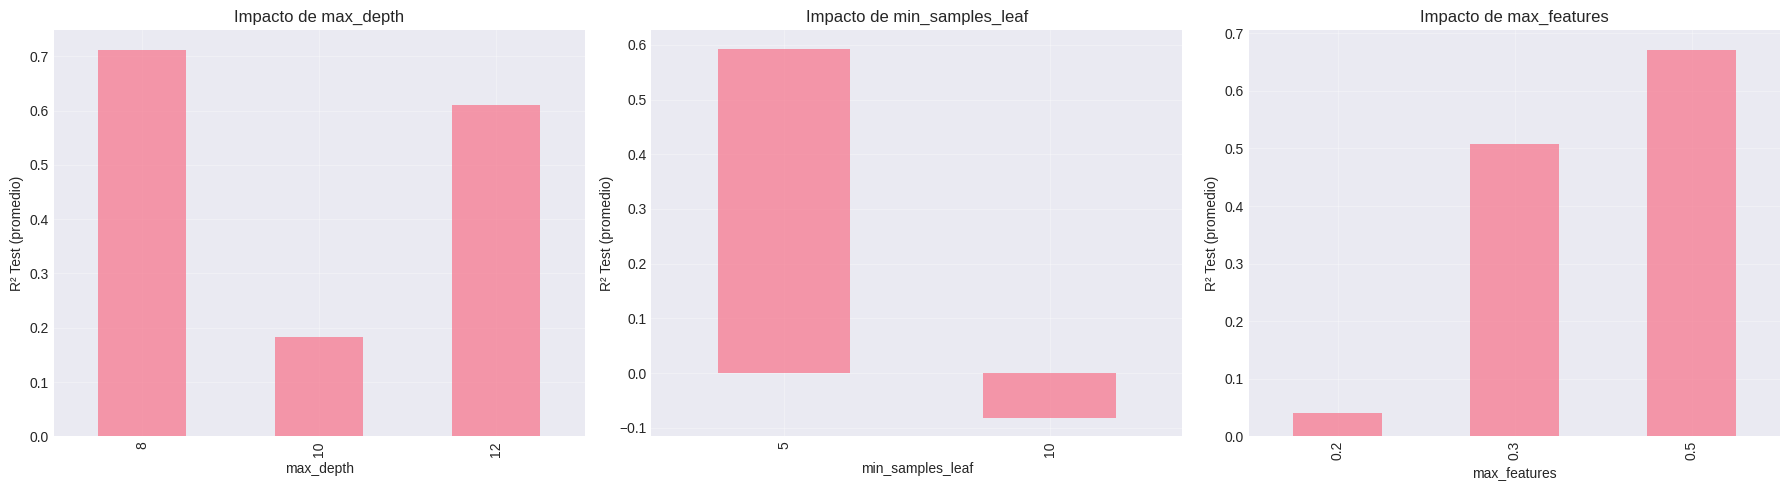

In [9]:
# Gráfico: R² Test vs Hiperparámetros
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# max_depth
ax = axes[0]
df_todos.groupby('max_depth')['Test_R2'].mean().plot(kind='bar', ax=ax, alpha=0.7)
ax.set_xlabel('max_depth')
ax.set_ylabel('R² Test (promedio)')
ax.set_title('Impacto de max_depth')
ax.grid(True, alpha=0.3)

# min_samples_leaf
ax = axes[1]
df_todos.groupby('min_samples_leaf')['Test_R2'].mean().plot(kind='bar', ax=ax, alpha=0.7)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('R² Test (promedio)')
ax.set_title('Impacto de min_samples_leaf')
ax.grid(True, alpha=0.3)

# max_features
ax = axes[2]
df_todos.groupby('max_features')['Test_R2'].mean().plot(kind='bar', ax=ax, alpha=0.7)
ax.set_xlabel('max_features')
ax.set_ylabel('R² Test (promedio)')
ax.set_title('Impacto de max_features')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/tuning_hiperparametros.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Recomendación Final

In [10]:
# Configuración recomendada
max_depth_rec = df_todos.groupby('max_depth')['Test_R2'].mean().idxmax()
min_samples_leaf_rec = df_todos.groupby('min_samples_leaf')['Test_R2'].mean().idxmax()
max_features_rec = df_todos.groupby('max_features')['Test_R2'].mean().idxmax()

print("="*70)
print("RECOMENDACIÓN FINAL")
print("="*70)
print("\nHiperparámetros óptimos (basado en promedio de R² Test):")
print(f"  max_depth: {max_depth_rec}")
print(f"  min_samples_leaf: {min_samples_leaf_rec}")
print(f"  max_features: {max_features_rec}")

# R² esperado con estos parámetros
r2_promedio = df_todos['Test_R2'].mean()
print(f"\nR² Test promedio: {r2_promedio:.4f}")

# Targets problemáticos
print("\n" + "="*70)
print("TARGETS PROBLEMÁTICOS:")
print("="*70)

for target in targets_problematicos:
    row = df_todos[df_todos['target']==target].iloc[0]
    print(f"\n{target}:")
    print(f"  Test R²: {row['Test_R2']:.4f}")
    print(f"  Params: max_depth={row['max_depth']}, min_samples_leaf={row['min_samples_leaf']}, max_features={row['max_features']}")
    
    if row['Test_R2'] > 0.1:
        print(f"  ✓ MEJORÓ con tuning")
    else:
        print(f"  ❌ No predecible con features meteorológicas")

print("\n" + "="*70)

RECOMENDACIÓN FINAL

Hiperparámetros óptimos (basado en promedio de R² Test):
  max_depth: 8
  min_samples_leaf: 5
  max_features: 0.5

R² Test promedio: 0.4429

TARGETS PROBLEMÁTICOS:

intensidad_termicas_mean_ms:
  Test R²: -0.0820
  Params: max_depth=10, min_samples_leaf=10, max_features=0.2
  ❌ No predecible con features meteorológicas

tasa_ascenso_mean_ms:
  Test R²: -0.0816
  Params: max_depth=10, min_samples_leaf=10, max_features=0.2
  ❌ No predecible con features meteorológicas



## 10. Guardar Resultados

In [11]:
df_todos.to_csv('../data/processed/tuning_resultados.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/tuning_resultados.csv")
print("  - data/processed/tuning_hiperparametros.png")
print("\n" + "="*70)
print("✓ TUNING DE HIPERPARÁMETROS COMPLETADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/tuning_resultados.csv
  - data/processed/tuning_hiperparametros.png

✓ TUNING DE HIPERPARÁMETROS COMPLETADO
